In [7]:
3#------------------- Import Libraries -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ProgbarLogger


To develop a predictive model or analytical insight that can distinguish between patients at risk of retinopathy versus those not at risk, using the available predictors (age, blood pressure, cholesterol).

Type of Problem: Binary classification (Yes/No for retinopathy)

Application: Early identification of at-risk patients for retinopathy, potentially helping in preventive care or targeted intervention.

In [8]:
df = pd.read_csv("pronostico_dataset.csv",sep = ';')

In [9]:
df.head()

,ID,age,systolic_bp,diastolic_bp,cholesterol,prognosis
0,0,77.196340,85.288742,80.021878,79.957109,retinopathy
1,1,63.529850,99.379736,84.852361,110.382411,retinopathy
2,2,69.003986,111.349455,109.850616,100.828246,retinopathy
3,3,82.638210,95.056128,79.666851,87.066303,retinopathy
4,4,78.346286,109.154591,90.713220,92.511770,retinopathy


In [10]:
df.shape

(6000, 6)

In [11]:
df = df.drop('ID',axis = 1)

In [12]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           6000 non-null   float64
 1   systolic_bp   6000 non-null   float64
 2   diastolic_bp  6000 non-null   float64
 3   cholesterol   6000 non-null   float64
 4   prognosis     6000 non-null   object 
dtypes: float64(4), object(1)
memory usage: 234.5+ KB


This dataset contains medical data on patients, aiming to predict the prognosis of retinopathy based on patient attributes. The key columns are:

ID (all zero in this sample; may indicate single-center or anonymized data)

age: Patient age (continuous variable)

systolic_bp: Systolic blood pressure (mmHg; continuous)

diastolic_bp: Diastolic blood pressure (mmHg; continuous)

cholesterol: Serum cholesterol level (mg/dL; continuous)

prognosis: Target variable; either "retinopathy" (presence) or "no_retinopathy" (absence)

In [14]:
df.describe()

,age,systolic_bp,diastolic_bp,cholesterol
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,60.464121,100.694822,90.505547,100.628255
std,8.564392,10.669267,9.648200,10.433915
min,35.164761,69.675429,62.807105,69.967453
25%,54.371941,93.267420,83.641788,93.202373
50%,59.831159,100.119926,89.912429,100.060637
75%,65.809652,107.439501,96.682405,107.250829
max,103.279497,151.699660,133.456382,148.233544


In [15]:
df.isnull().sum()

age             0
systolic_bp     0
diastolic_bp    0
cholesterol     0
prognosis       0
dtype: int64

In [16]:
df=df.dropna()

prognosis
retinopathy       3087
no_retinopathy    2913
Name: count, dtype: int64


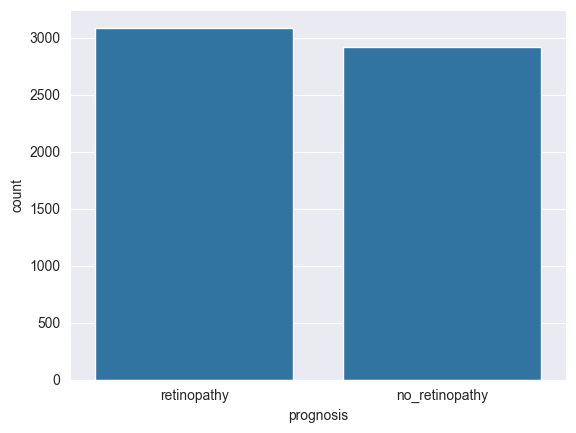

In [17]:
print(df['prognosis'].value_counts())
sns.countplot(x='prognosis', data=df)
plt.show()

Here,
* The bar heights represent the number of instances in each class.

* There is a slightly higher number of cases with retinopathy than without,but the distribution is relatively balanced.   



In [18]:
df['prognosis'].unique()

array(['retinopathy', 'no_retinopathy'], dtype=object)

In [19]:
df['prognosis'] = (
    df['prognosis']
    .astype(str)                   # Convert None/NaN to 'nan' temporarily
    .str.strip()                   # Remove leading/trailing whitespace
    .str.lower()                   # Convert to lowercase
    .map({'retinopathy': 1, 'no_retinopathy': 0})      # Map to binary
)

In [20]:
X = df.drop('prognosis',axis = 1)

In [21]:
y = df['prognosis']

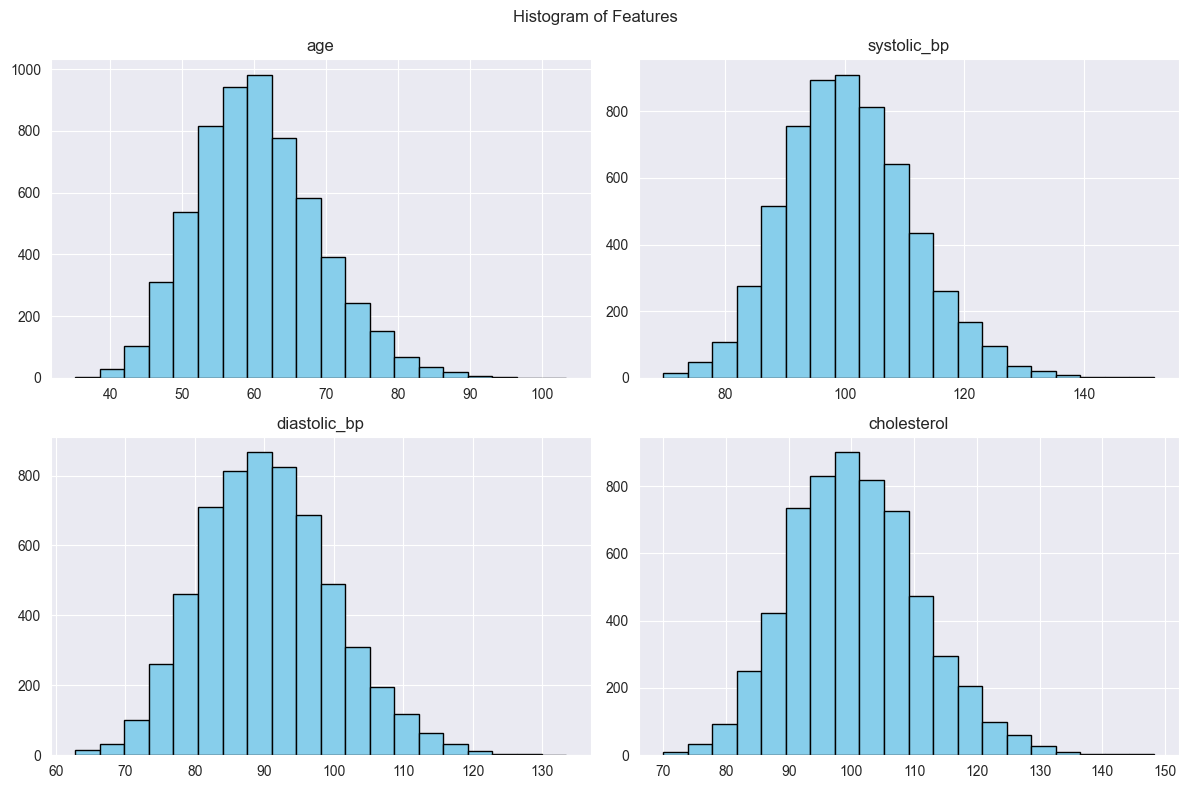

In [22]:
X.hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Histogram of Features")
plt.tight_layout()
plt.show()

Here,
*  These histograms helps assess the distribution and skewness of each feature.

*   Most variables are normally distributed,which is helpful for many statistical and machine learning models

*   No severe skewness or unusual patterns are visible,indicating clean and balanced data.


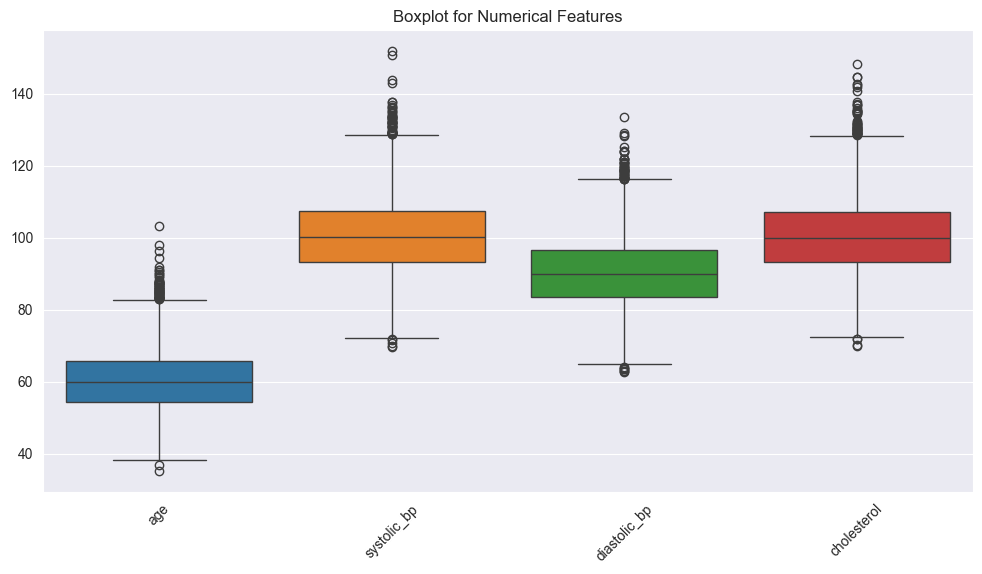

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.title("Boxplot for Numerical Features")
plt.xticks(rotation=45)
plt.show()

Here,
*   Outliers were detected in all numerical features using boxplots.

*  The presence of outliers suggests potential variability or noise in the dataset, which can affect model training and predictions.
*   It may be necessary to treat outliers using techniques such as IQR-based filtering, winsorization, or robust scaling, depending on the model sensitivity.


* These boxplots serve as a key visual diagnostic to understand the spread and anomalies in the features.  



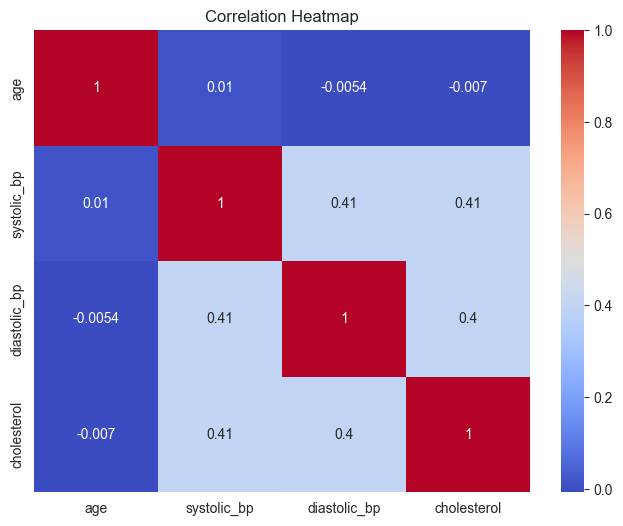

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Here,
*   The heatmap shows how the features are related to each other.

*   systolic_bp, diastolic_bp, and cholesterol have a moderate positive relationship (around 0.4).

*   age has very low or no correlation with the other features.

*   This means changes in age do not strongly affect the other variables.
*   The heatmap helps us understand which features move together and may help in feature selection.
  




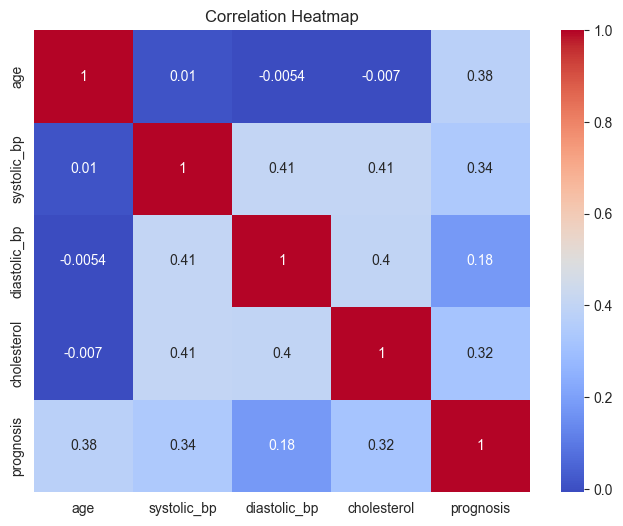

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [26]:
numeric_cols = X.select_dtypes(include='number')

def detect_outliers_iqr(data):
    outliers = {}
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        outliers[col] = outlier_count
    return pd.Series(outliers)


outliers_found = detect_outliers_iqr(numeric_cols)
print("Number of outliers in each numerical column:\n")
print(outliers_found)

Number of outliers in each numerical column:

age             65
systolic_bp     55
diastolic_bp    55
cholesterol     54
dtype: int64


We are using the Interquartile Range (IQR) technique to detect outliers in each numerical column.

- IQR measures the middle spread of the data (between the 25th and 75th percentiles).
- Any value that lies 1.5 × IQR below Q1 or above Q3 is considered an outlier.
- This method works well for identifying extreme values without being affected by the mean or standard deviation.

In [27]:
X.skew()

age             0.441141
systolic_bp     0.334655
diastolic_bp    0.336555
cholesterol     0.361514
dtype: float64

We are checking the skewness of each numeric column using `.skew()`.

- Skewness tells us how the data is distributed:
  - A skewness near 0 means the data is fairly symmetrical.
  - A positive skew means the data has a longer tail on the right (more high values).
  - A negative skew means a longer tail on the left (more low values).

In [28]:
def winsorize_iqr(data):
    numeric_cols = data.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        data[col] = data[col].clip(lower, upper)

    return data

##### winsorize_iqr works like this:

- If a value is less than the lower bound - it is replaced with the lower bound
- If a value is greater than the upper bound - it is replaced with the upper bound
- Values within the range are unchanged

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           6000 non-null   float64
 1   systolic_bp   6000 non-null   float64
 2   diastolic_bp  6000 non-null   float64
 3   cholesterol   6000 non-null   float64
dtypes: float64(4)
memory usage: 187.6 KB


In [30]:
X = winsorize_iqr(X)

In [31]:
X.shape

(6000, 4)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- normalize data to ensure that every feature contributes fairly and to improve the performance and stability of ML algorithms
- Tree-based models (Decision Trees, Random Forests, XGBoost) don't require normalization
- probabilistic models(Naive Bayes) that don’t use distance metrics or gradient

In [33]:
X_scaled

array([[ 1.98780321, -1.45758536, -1.09476087, -2.00360948],
       [ 0.36809089, -0.12108382, -0.58884773,  0.95146283],
       [ 1.01686947,  1.01421926,  2.02930566,  0.02350989],
       ...,
       [-0.57620663, -0.2119756 ,  1.2801745 ,  1.97065304],
       [ 0.36087392,  0.58359391, -0.25283452,  0.53089025],
       [ 0.24684488, -0.35620729, -0.37669204,  0.78081579]],
      shape=(6000, 4))

Model Building

In [34]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,stratify = y ,test_size = 0.2)

In [35]:
# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [36]:
#Feature Scaling for ANN, SVM, KNN, Ensemble
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Hyperparameter tuning

In [37]:
#Hyperparameter Grids
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}
dt_params = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': [None, 'balanced']
}
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}

In [38]:
# Hyperparameter Tuning Function
def tune_model(model, params, X_train, y_train):
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Tuned {model.__class__.__name__} - Best params: {grid.best_params_}")
    return grid.best_estimator_

In [39]:
print("Starting hyperparameter tuning for scikit-learn models...")
rf_best = tune_model(RandomForestClassifier(random_state=42), rf_params, X_train, y_train)
dt_best = tune_model(DecisionTreeClassifier(random_state=42), dt_params, X_train, y_train)
lr_best = tune_model(LogisticRegression(max_iter=1000, random_state=42), lr_params, X_train, y_train)
svm_best = tune_model(SVC(probability=True, random_state=42), svm_params, X_train_scaled, y_train)
knn_best = tune_model(KNeighborsClassifier(), knn_params, X_train_scaled, y_train)


Starting hyperparameter tuning for scikit-learn models...
Tuned RandomForestClassifier - Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Tuned DecisionTreeClassifier - Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned LogisticRegression - Best params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned SVC - Best params: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Tuned KNeighborsClassifier - Best params: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'}


In [40]:
# -------------------- Ensemble Model ----------------------
ensemble = VotingClassifier(
    estimators=[ ('lr', lr_best), ('svm', svm_best)],
    voting='soft'
)
ensemble.fit(X_train_scaled, y_train)


,estimators,"[('lr', ...), ('svm', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True


    Building an ANN model

In [41]:
# ------------------ Models Dictionary ---------------------
models = {
    'Random Forest': rf_best,
    'Decision Tree': dt_best,
    'Logistic Regression': lr_best,
    'SVM': svm_best,
    'KNN': knn_best,
    'Ensemble': ensemble,
}



==================== Evaluating Random Forest ====================
Accuracy: 0.7125
ROC AUC: 0.7945
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       583
           1       0.71      0.75      0.73       617

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.71      0.71      0.71      1200

Confusion Matrix:
[[390 193]
 [152 465]]
5-Fold CV Accuracy: 0.7390 ± 0.0068

==================== Evaluating Decision Tree ====================
Accuracy: 0.6742
ROC AUC: 0.7003
Classification Report:


C:\Python\python_basics\fraud_analysis\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Python\python_basics\fraud_analysis\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.60      0.64       583
           1       0.66      0.74      0.70       617

    accuracy                           0.67      1200
   macro avg       0.68      0.67      0.67      1200
weighted avg       0.68      0.67      0.67      1200

Confusion Matrix:
[[350 233]
 [158 459]]
5-Fold CV Accuracy: 0.6987 ± 0.0124

==================== Evaluating Logistic Regression ====================
Accuracy: 0.7317
ROC AUC: 0.8040
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       583
           1       0.73      0.75      0.74       617

    accuracy                           0.73      1200
   macro avg       0.73      0.73      0.73      1200
weighted avg       0.73      0.73      0.73      1200

Confusion Matrix:
[[414 169]
 [153 464]]
5-Fold CV Accuracy: 0.7442 ± 0.0089


C:\Python\python_basics\fraud_analysis\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(



==================== Evaluating SVM ====================
Accuracy: 0.7300
ROC AUC: 0.8003
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       583
           1       0.73      0.76      0.74       617

    accuracy                           0.73      1200
   macro avg       0.73      0.73      0.73      1200
weighted avg       0.73      0.73      0.73      1200

Confusion Matrix:
[[406 177]
 [147 470]]
5-Fold CV Accuracy: 0.7502 ± 0.0065

==================== Evaluating KNN ====================
Accuracy: 0.7142
ROC AUC: 0.7699
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       583
           1       0.72      0.72      0.72       617

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.71      0.71      0.71      1200

Confusion Matrix:
[[410 173]
 [170 447]]


C:\Python\python_basics\fraud_analysis\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Python\python_basics\fraud_analysis\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


Accuracy: 0.7333
ROC AUC: 0.8072
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       583
           1       0.74      0.75      0.74       617

    accuracy                           0.73      1200
   macro avg       0.73      0.73      0.73      1200
weighted avg       0.73      0.73      0.73      1200

Confusion Matrix:
[[420 163]
 [157 460]]
5-Fold CV Accuracy: 0.7460 ± 0.0116


C:\Python\python_basics\fraud_analysis\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

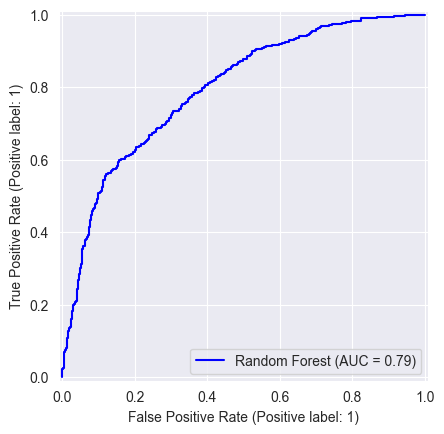

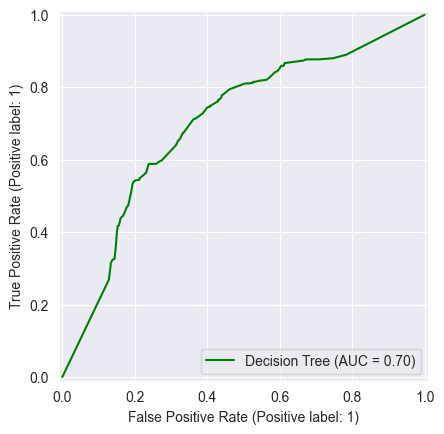

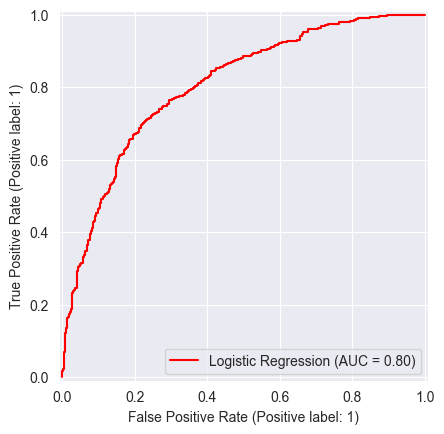

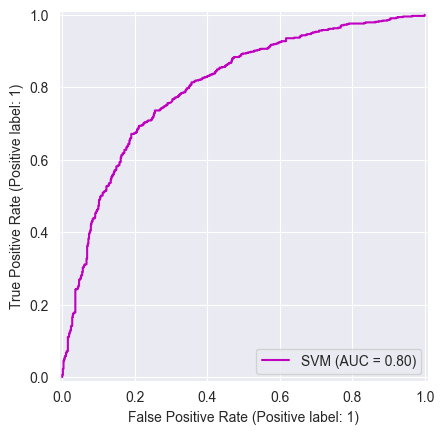

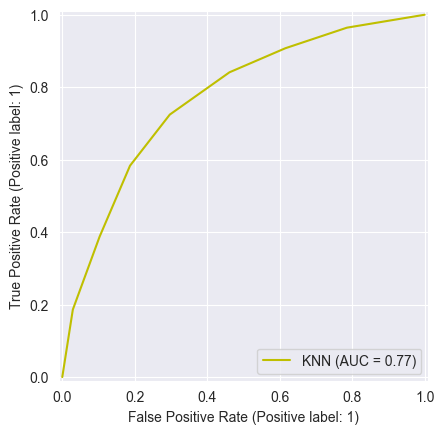

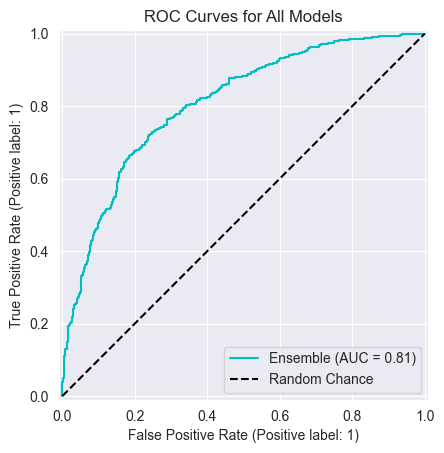

In [42]:
# -------------- Evaluation & Visualization ----------------
results = []
plt.figure(figsize=(10, 8))
model_colors = ['b', 'g', 'r', 'm', 'y', 'c']

for i, (name, model) in enumerate(models.items()):
    print(f"\n{'='*20} Evaluating {name} {'='*20}")
    # Determine input data type
    X_eval = X_test_scaled if name in ['SVM', 'KNN', 'Ensemble'] else X_test

    # Get predictions
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_eval)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)  # Threshold at 0.5
    else:
        y_pred = model.predict(X_eval)
        y_proba = None

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # Print and store results
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC: {auc:.4f}" if not np.isnan(auc) else "ROC AUC: N/A")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_mat)
    print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    results.append({
        'Model': name,
        'Test Accuracy': acc,
        'ROC AUC': auc,
        'CV Accuracy Mean': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std()
    })

    # Plot ROC curve if applicable
    if not np.isnan(auc):
        RocCurveDisplay.from_predictions(
            y_test,
            y_proba,
            name=name,
            color=model_colors[i % len(model_colors)]
        )
plt.title("ROC Curves for All Models")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.legend()
plt.show()


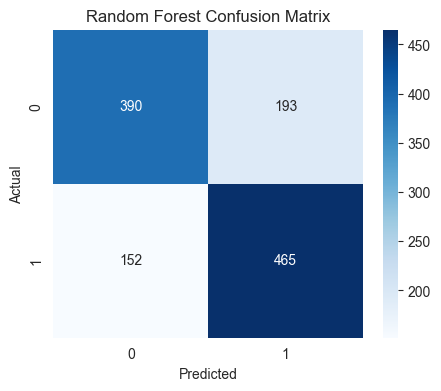

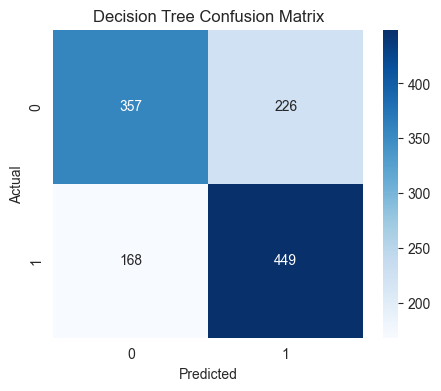

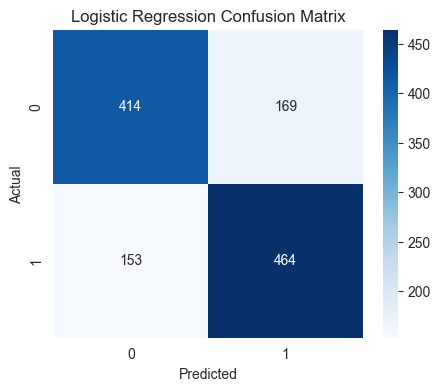

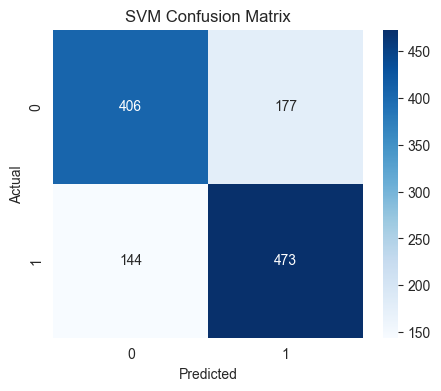

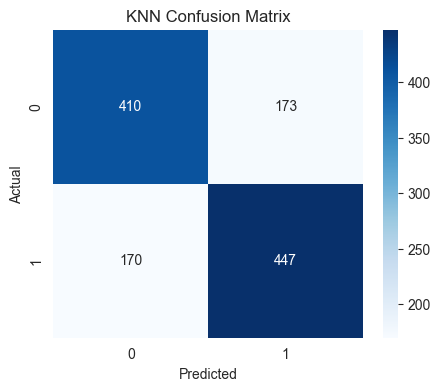

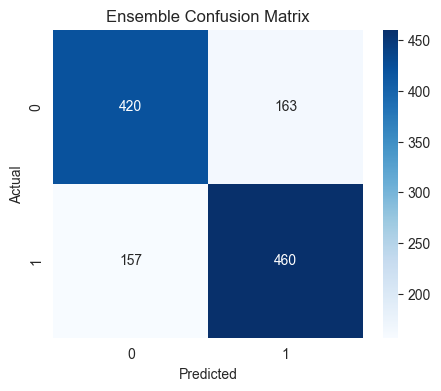

In [43]:
# Confusion matrices
for name, model in models.items():
    X_eval = X_test_scaled if name in ['SVM', 'KNN', 'Ensemble'] else X_test
    y_pred = model.predict(X_eval)
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.show()


In [44]:
# Summary table
results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print("\n" + "=" * 40)
print("Summary of Model Performance\n")
print(results_df[['Model', 'Test Accuracy', 'ROC AUC', 'CV Accuracy Mean', 'CV Accuracy Std']])
print("=" * 40)


Summary of Model Performance

                 Model  Test Accuracy   ROC AUC  CV Accuracy Mean  \
0             Ensemble       0.733333  0.807192          0.746000   
1  Logistic Regression       0.731667  0.804009          0.744167   
2                  SVM       0.730000  0.800263          0.750167   
3                  KNN       0.714167  0.769878          0.723667   
4        Random Forest       0.712500  0.794466          0.739000   
5        Decision Tree       0.674167  0.700251          0.698667   

   CV Accuracy Std  
0         0.011600  
1         0.008882  
2         0.006549  
3         0.007257  
4         0.006819  
5         0.012412  


In [45]:
# Feature importance visualization for Tree models
def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    plt.title(f'Feature Importances for {model_name}')
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.tight_layout()
    plt.show()

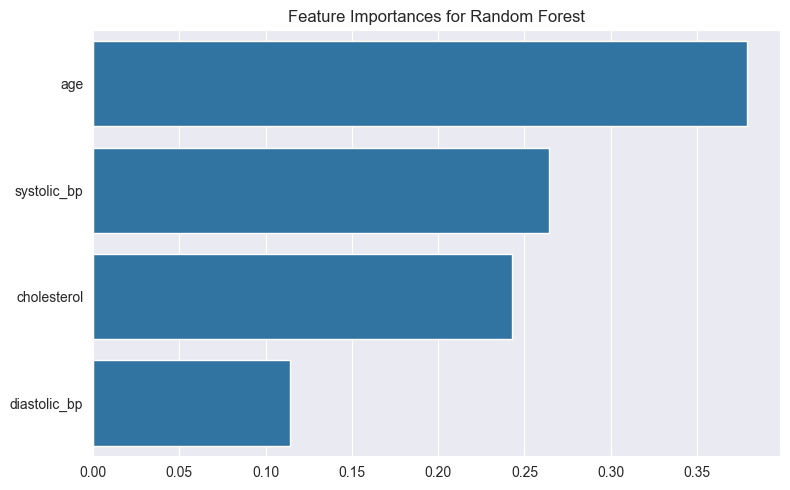

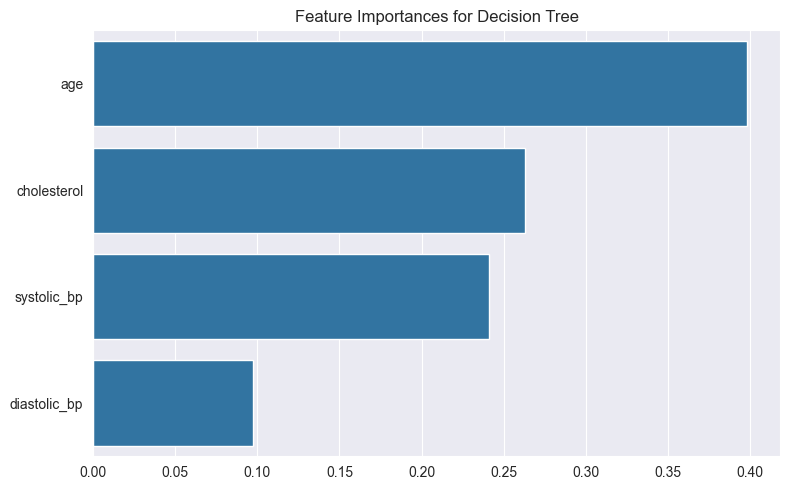


Best performing model: Ensemble


In [46]:
if hasattr(rf_best, "feature_importances_"):
    plot_feature_importance(rf_best, X.columns, "Random Forest")
if hasattr(dt_best, "feature_importances_"):
    plot_feature_importance(dt_best, X.columns, "Decision Tree")

# Best model print and save
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")

In [58]:
import pickle, json
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score


feature_order = list(X.columns)

# Best params
model = SVC(
    kernel='rbf',
    C=0.1,
    gamma='scale',
    probability=True
)

model.fit(X_train_scaled, y_train)

# Save model + scaler + feature order
with open("svm_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)  # from your earlier fit

with open("feature_order.json", "w") as f:
    json.dump(feature_order, f)


In [60]:
import pickle, json
import numpy as np
import streamlit as st
from pathlib import Path

st.set_page_config(page_title="Diabetic Retinopathy Prediction")
st.title("Diabetic Retinopathy Prediction")

# Load model, scaler, and feature order
try:
    with open("svm_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("feature_order.json", "r") as f:
        feature_order = json.load(f)
except Exception as e:
    st.error(f"Failed to load model/scaler/feature_order: {e}")
    st.stop()

app_code = """
import json, pickle, numpy as np, streamlit as st

st.set_page_config(page_title="Diabetic Retinopathy Prediction")
st.title("Diabetic Retinopathy Prediction")

# Load model, scaler, and feature order
with open("svm_model.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open("feature_order.json", "r") as f:
    feature_order = json.load(f)

# UI
col1, col2 = st.columns(2)
with col1:
    age = st.slider("Age (years)", 0, 100, 50)
    systolic_bp = st.number_input("Systolic BP", 50.0, 250.0, 120.0)
with col2:
    diastolic_bp = st.number_input("Diastolic BP ", 30.0, 150.0, 80.0)
    cholesterol = st.number_input("Cholesterol ", 50.0, 500.0, 180.0)

# Prepare input
vals = {'age': age, 'systolic_bp': systolic_bp, 'diastolic_bp': diastolic_bp, 'cholesterol': cholesterol}
x = np.array([[vals[c] for c in feature_order]], dtype=float)


if st.button("Predict"):
    pred = int(model.predict(x)[0])
    proba = float(model.predict_proba(x)[0][1])

    if pred == 1:
        st.markdown("### Retinopathy: **Yes**")
    else:
        st.markdown("### Retinopathy: **No**")
"""

Path("app.py").write_text(app_code, encoding="utf-8")

2025-08-12 19:33:33.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-12 19:33:33.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-12 19:33:33.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-12 19:33:33.784 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1140